In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.trials_data import TrialsData
import os 

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros(int(np.floor(d_shape[1]/step)))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[count] = np.mean(data[:,i_step:i_step+win])
        count +=1
    return d_avg

In [4]:
filepath ="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-12-02_11-01-23_Riesling_lip_e1_r1.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [5]:
b1 = np.where(data.block == 1)[0][0]
trial_idx = np.where(data.trial_error[b1:] == 0)[0] 

In [12]:
# Select trials and create task frame
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=data.condition[trial_idx],
    test_stimuli=data.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)

cgroup = "all"
neurons = np.where(data.clustersgroup != cgroup)[0]
print("Number of clusters: %d" % len(data.clustersgroup))
print("Number of %s units: %d" % (cgroup, len(neurons)))

Number of clusters: 18
Number of all units: 18


In [ ]:
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=data.condition[trial_idx],
        test_stimuli=data.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    if cgroup == 'all':
        neurons = np.where(data.clustersgroup != cgroup)[0]
    else:
        neurons = np.where(data.clustersgroup == cgroup)[0]

    task = task[np.logical_and(np.in1d(task['i_neuron'].values,neurons),task['in_out']==in_out)]

    if to_decode == 'samples': 
        task=task[task['sample']!='o0_c0']
    elif to_decode == 'neutral':
        task['sample'].replace(['o1_c1', 'o1_c5', 'o5_c1', 'o5_c5'],'no_neutral',inplace=True)
    else:
        print('Error: to_decode must be "samples" or "neutral"')

    # split in two groups where the neurons in each have the same trials in in or out
    task_1 = task[task['i_neuron']==neurons[0]].copy()
    trials_neuron = task_1['trial_idx'].values
    task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
    t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
    t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
    task_all = [task_1]
    if len(t_neurons_2) != 0:
        trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
        trials_neuron = [trials_neuron,trials_neuron_2]
        t_neurons = [t_neurons,t_neurons_2]
        task_2 = task[task['i_neuron']==t_neurons_2[0]].copy()
        task_2['trial_idx'] = task_2['trial_idx'].replace(trials_neuron_2,np.arange(0,len(trials_neuron_2)))
        task_all = [task_1,task_2]
    else:
        trials_neuron = [trials_neuron]
        t_neurons = [t_neurons]
    

    sp_avg_all = []
    for i_task, (trial_idx_n, neurons,task) in enumerate(zip(trials_neuron,t_neurons,task_all)):
        min_task = task.groupby(["sample"]).count().min().min()
        # check number of trials
        if min_task>=30:
            trials_s_on = data.code_samples[
                trial_idx[trial_idx_n],
                np.where(data.code_numbers[trial_idx[trial_idx_n]] == task_constants.EVENTS_B1["sample_on"])[
                    1
                ],
            ]
            shifts = -(trials_s_on - t_before).astype(int)
            shifts = shifts[:,np.newaxis]
            shift_sp = TrialsData.indep_roll(data.sp_samples[trial_idx[trial_idx_n]][:,neurons], shifts, axis=2)[:,:, :1600]
            sp_avg = moving_average(shift_sp, win=win, step=step)
            sp_avg_all.append(sp_avg)
        else:
            task_all.pop(i_task)

In [13]:
if cgroup == 'all':
    neurons = np.where(data.clustersgroup != cgroup)[0]
else:
    neurons = np.where(data.clustersgroup == cgroup)[0]

In [8]:
in_out='in'
#i_neuron = neurons[1]
task=task[task['in_out']==in_out]

In [9]:
task_sample = task.loc[task['sample'].str.contains("c1", case=False)]
task_sample = task_sample[task_sample['n_test_stimuli']!=1]
trials_n = task_sample['trial_idx'].values
#trials_n = trial_idx[trials_n]

In [10]:
task

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,2,o1_c1,in,3,3
1,0,3,o1_c1,in,1,1
2,0,10,o0_c0,in,5,7
3,0,11,o1_c1,in,3,3
4,0,13,o1_c1,in,2,2
...,...,...,...,...,...,...
9931,17,513,o5_c5,in,1,1
9932,17,517,o5_c5,in,3,3
9933,17,519,o5_c5,in,1,1
9934,17,527,o5_c5,in,3,3


In [14]:
test_stimuli=np.array(data.test_stimuli[trial_idx[trials_n]],dtype=str)
test_stimuli = np.where(np.logical_or(test_stimuli=='11.0',test_stimuli=='51.0'),'nan',test_stimuli)
test_stimuli

/tmp/ipykernel_9851/1404605455.py:1: RuntimeWarning: invalid value encountered in cast
  test_stimuli=np.array(data.test_stimuli[trial_idx[trials_n]],dtype=str)


array([['85.0', '16.0', 'nan', 'nan', 'nan'],
       ['14.0', '62.0', 'nan', 'nan', 'nan'],
       ['73.0', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['81.0', 'nan', 'nan', 'nan', 'nan'],
       ['24.0', '71.0', 'nan', 'nan', 'nan'],
       ['54.0', '86.0', 'nan', 'nan', 'nan']], dtype='<U32')

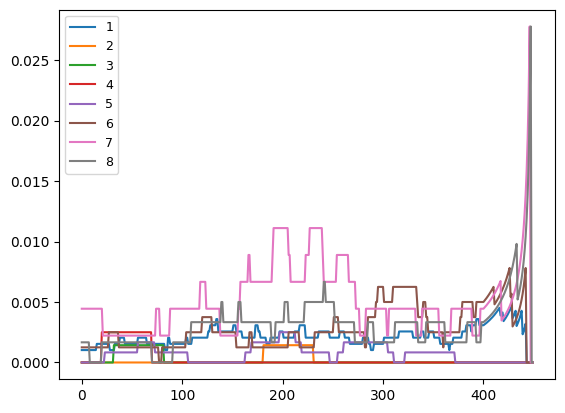

In [174]:
color = '1'
for color in range(1,9):
    
    rows, cols = np.where(np.core.defchararray.find(test_stimuli,str(color))==0) # the rows are the trials and columns the n test stimuli
    code_numbers = data.code_numbers[trial_idx[trials_n]] 
    code_samples = data.code_samples[trial_idx[trials_n]] 
    _, cols_code = np.where(code_numbers == task_constants.EVENTS_B1['test_on_1'])
    code_numbers = code_numbers[:,cols_code[0]:]
    timestamps = np.array(code_samples[rows,cols],dtype=int)
    sp_trials = []
    sp =data.sp_samples[trial_idx[trials_n]][:,i_neuron]
    for i_trial,i_ts in zip(rows,timestamps):
        sp_trials.append(sp[i_trial,i_ts:i_ts+450])
    d_avg = moving_average(data=np.array(sp_trials),win=50, step=1)
    plt.plot(d_avg,label=color)
    plt.legend(fontsize=9)

In [175]:
sp_trials

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [176]:
color

8

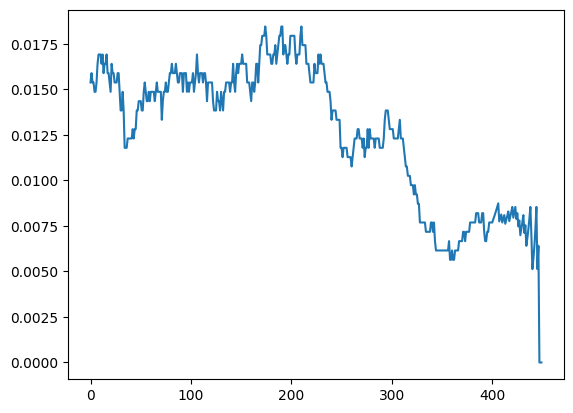

In [115]:
i_ts

1015